# Figure 3: Modern population t-SNE embedding

In [1]:
import pandas as pd
import skbio
import sklearn
from plotnine import *
import numpy as np
import multiprocessing
from functools import partial
from ete3 import NCBITaxa
from io import StringIO
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa as skbio_mds
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from skbio import TreeNode

In [2]:
seed=42
np.random.seed(seed)

In [3]:
modern_sources = pd.read_csv("../../data/sourcepredict/modern_gut_microbiomes_sources.csv", index_col=0)
modern_labels = pd.read_csv("../../data/sourcepredict/modern_gut_microbiomes_labels.csv", index_col=0)
source_labels = pd.read_csv("../../tables/table_s3_reference_sample_acc_list.csv", sep=";", index_col=0)

In [4]:
source_labels = source_labels.set_index(source_labels.index.str.replace(" ",""))

In [5]:
def gmpr_size_factor(col, ar):
    pr = np.apply_along_axis(lambda x: np.divide(ar[:, col], x), 0, ar)
    pr[np.isinf(pr)] = np.nan
    pr[pr == 0] = np.nan
    pr_median = np.nanmedian(pr, axis=0)
    return(np.exp(np.mean(np.log(pr_median))))

def GMPR_normalize(df, process):
    """
    Global Mean of Pairwise Ratios
    Chen, L., Reeve, J., Zhang, L., Huang, S., Wang, X., & Chen, J. (2018). 
    GMPR: A robust normalization method for zero-inflated count data 
    with application to microbiome sequencing data. 
    PeerJ, 6, e4600.
    """
    ar = np.asarray(df)

    gmpr_sf_partial = partial(gmpr_size_factor, ar=ar)
    with multiprocessing.Pool(process) as p:
        sf = p.map(gmpr_sf_partial, list(range(np.shape(ar)[1])))

    return(pd.DataFrame(np.divide(ar, sf), index=df.index, columns=df.columns))

## GMPR Normalization

In [6]:
modern_norm = GMPR_normalize(modern_sources, process=10)

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value e

### Dividing dataset intro train and test

In [7]:
training = modern_norm.sample(frac=0.8, axis = 1)

In [8]:
test = modern_norm.drop(training.columns, axis=1)

#### Panel A: Embedding of the training dataset

**Computing the distance matrix**

In [9]:
 def compute_distance(df, rank='species'):
        """
        Sample pairwise distance computation
        Args:
            - rank(str): Taxonomics rank to keep for filtering OTUs
        """

        # Getting a single Taxonomic rank
        ncbi = NCBITaxa()
        only_rank = []
        for i in list(df.index):
            try:
                if ncbi.get_rank([i])[i] == rank:
                    only_rank.append(i)
            except KeyError:
                continue
        df_rank = df.loc[only_rank, :].T
        tree = ncbi.get_topology(list(df_rank.columns), intermediate_nodes=False)
        newick = TreeNode.read(StringIO(tree.write()))
        df_wu = beta_diversity("weighted_unifrac", counts=df_rank.values.astype(int), ids=list(df_rank.index), otu_ids=[str(i) for i in list(df_rank.columns)], tree=newick)
        df_wu = df_wu.to_data_frame()
        return(df_wu)

In [10]:
training_wu_df = compute_distance(training)

**TSNE Embedding**

In [11]:
tsne = TSNE(metric='precomputed',n_components=2, random_state=seed)
train_embed = tsne.fit(np.matrix(training_wu_df))

In [12]:
train_embed = pd.DataFrame(train_embed.embedding_, columns = ['DIM1','DIM2'], index = training_wu_df.index)

In [13]:
train_embed_plot =train_embed.merge(source_labels, left_index=True, right_index=True)

In [14]:
train_embed_plot.to_csv("results/train_embed_plot.csv")

In [30]:
train_embed_plot = pd.read_csv("results/train_embed_plot.csv", index_col=0)

In [36]:
train_embed_plot['Type'] = train_embed_plot['Type'].str.replace('Canis familiaris','Dog').replace('Non Westernized Human', 'Non Westernized human / Rural').replace('Westernized human', 'Westernized human / Urban')
train_embed_plot['Type'] = pd.Categorical(train_embed_plot['Type'], categories=['Non Westernized human / Rural', 'Westernized human / Urban','Dog', 'Soil'], ordered=True)

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:706: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:707: PlotnineWarning: Filename: results/figure3A.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


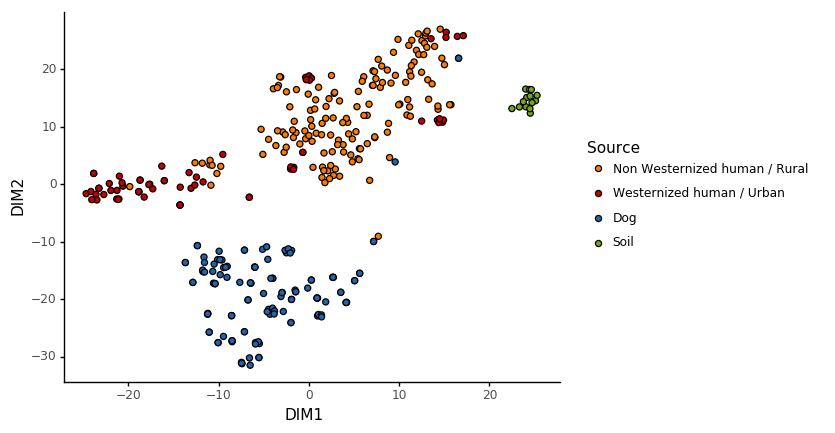

In [38]:
p = ggplot(train_embed_plot, aes(x='DIM1',y='DIM2')) + geom_point(aes(fill='Type'), stroke=0.5, color='black', size = 2)
p = p + scale_fill_manual(name = 'Source', values = {"Dog":"#2166ac", "Non Westernized human / Rural":"#ff7b00", "Westernized human / Urban":"#c40000", "Soil":"#75a51c"}) + theme_classic()
p.draw()
p.save('results/figure3A.png', dpi=300)

#### Panel B: Embedding training and test dataset, then KNN to predict test sources

In [39]:
training_labels = modern_labels.loc[training_wu_df.index,:]

**Computing the distance matrix on all data**

In [40]:
all_wu_df = compute_distance(modern_sources)

**TSNE Embedding**

In [41]:
all_embed = tsne.fit(np.matrix(all_wu_df))

In [42]:
all_embed = pd.DataFrame(all_embed.embedding_, columns = ['DIM1','DIM2'], index = all_wu_df.index)

In [43]:
all_embed

,DIM1,DIM2
SRR1175007,-5.868009,23.966011
SRR042182,-2.575737,18.508326
SRR061154,-4.845985,26.702312
SRR061499,-2.719011,21.911171
SRR063469,-4.245211,18.902060
SRR062324,-3.230138,21.865330
SRR1179037,-5.463374,24.208561
SRR061236,-5.153660,25.393593
SRR061456,-4.295001,24.603697
SRR642021,-0.919046,26.423836


In [44]:
all_embed = all_embed.merge(source_labels['Type'], left_index=True, right_index=True)

#### KNN machine learning

**Splitting the train dataset in training and validation**

In [45]:
train_ds = all_embed.loc[train_embed.index,:]

In [46]:
test_ds = all_embed.drop(train_ds.index, axis=0)

In [47]:
train_features, valid_features, train_labels, valid_labels = train_test_split(train_ds.drop('Type', axis=1), 
                                                                              train_ds.loc[:, 'Type'], 
                                                                              test_size=0.2, 
                                                                              random_state=seed)

In [48]:
train_with_labels = train_features.merge(train_labels, left_index=True, right_index=True)

In [49]:
train_features, valid_calibrate_features, train_labels, valid_calibrate_labels = train_test_split(train_with_labels.drop('Type', axis=1), 
                                                                              train_with_labels.loc[:, 'Type'], 
                                                                              test_size=0.2, 
                                                                              random_state=seed)

**Cross validation search of best KNN parameters (Number of Neighbors)**

In [50]:
knn = KNeighborsClassifier(n_jobs=10)

In [51]:
param_knn_grid = {'n_neighbors': [10, 20, 50]}

In [52]:
CV_knn = GridSearchCV(estimator=knn, param_grid=param_knn_grid, cv=3, n_jobs=10)

In [53]:
CV_knn.fit(train_features, train_labels)

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=10,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=10, param_grid={'n_neighbors': [10, 20, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

**Training the KNN classifier with best parameters**

In [54]:
knn1 = KNeighborsClassifier(n_neighbors=CV_knn.best_params_['n_neighbors'], weights='distance', n_jobs=10)

In [55]:
knn1.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=10, n_neighbors=10, p=2,
                     weights='distance')

**Prediction the validation source labels**

In [56]:
y_pred = knn1.predict(valid_features)

In [57]:
print("Validation Accuracy:", round(metrics.accuracy_score(valid_labels, y_pred), 2))

Validation Accuracy: 0.99


**Correcting Trained KNN model for Class probability estimation with Platt scaling**

In [58]:
cal_knn = CalibratedClassifierCV(knn1, cv='prefit', method='sigmoid')

In [59]:
cal_knn.fit(valid_calibrate_features, valid_calibrate_labels)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(algorithm='auto',
                                                           leaf_size=30,
                                                           metric='minkowski',
                                                           metric_params=None,
                                                           n_jobs=10,
                                                           n_neighbors=10, p=2,
                                                           weights='distance'),
                       cv='prefit', method='sigmoid')

**Predicting the labels of the test dataset**

In [60]:
test_pred = cal_knn.predict(test_ds.drop('Type', axis=1))

In [61]:
print("Test Accuracy:", round(metrics.accuracy_score(test_ds['Type'], test_pred), 2))

Test Accuracy: 0.99


In [62]:
predict_ds = test_ds.drop('Type', axis=1)

In [63]:
predict_ds['Type'] = test_pred

In [64]:
combined_test = test_ds.append(predict_ds)

In [65]:
combined_test['ml'] = ['Actual']*test_ds.shape[0]+['Predicted']*predict_ds.shape[0]

In [66]:
combined_test['ml'] = combined_test['ml'].astype('category').cat.reorder_categories(['Actual','Predicted'])

In [68]:
combined_test['Type'] = combined_test['Type'].str.replace('Canis familiaris','Dog').replace('Non Westernized Human', 'Non Westernized human / Rural').replace('Westernized human', 'Westernized human / Urban')
combined_test['Type'] = pd.Categorical(combined_test['Type'], categories=['Non Westernized human / Rural', 'Westernized human / Urban','Dog', 'Soil'], ordered=True)

In [80]:
combined_test_actual = combined_test.query('ml == "Actual"')
combined_test_actual['size'] = combined_test_actual.shape[0] * [3]

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [83]:
combined_test_predicted = combined_test.query('ml == "Predicted"')
combined_test_predicted['size'] = combined_test_predicted.shape[0] * [1]

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:706: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:707: PlotnineWarning: Filename: results/figure3B.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


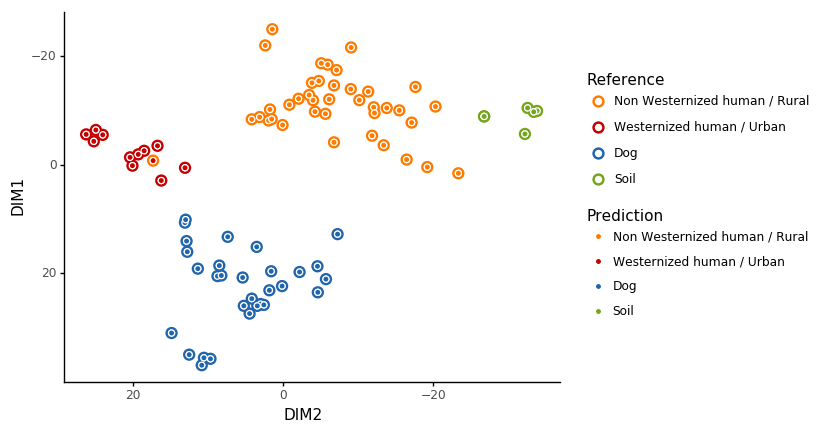

In [112]:
p = ggplot(combined_test_actual, aes(x='DIM1',y='DIM2')) + geom_point(aes(color='Type'), size=3, shape='o', fill = 'white', stroke=1)
p = p + geom_point(data=combined_test_predicted, mapping=aes(x='DIM1',y='DIM2', fill='Type'), size=2, color='white', stroke=0.5)
p = p + scale_color_manual(name = 'Reference', values = {"Dog":"#2166ac", "Non Westernized human / Rural":"#ff7b00", "Westernized human / Urban":"#c40000", "Soil":"#75a51c"})
p = p + theme_classic() + scale_fill_manual(name = 'Prediction', values = {"Dog":"#2166ac", "Non Westernized human / Rural":"#ff7b00", "Westernized human / Urban":"#c40000", "Soil":"#75a51c"})
p = p +  coord_flip() + scale_y_reverse() + scale_x_reverse() 
p.draw()
p.save('results/figure3B.png', dpi=300)